# Machine Learning  - Forecasting 
## Time Series

El objetivo de este notebook es entregar el detalle del proceso de implementación para el analisis de una serie temporal.

Una serie temporal es un conjunto de muestras tomadas a intervalos de tiempo regulares. Es interesante analizar su comportamiento al mediano y largo plazo, intentando detectar patrones y poder hacer pronósticos de cómo será su comportamiento futuro. Lo que hace especial a una "Time Series" a diferencia de un problema de "Regresión" son dos cosas:

* Es dependiente del Tiempo. Esto rompe con el requerimiento que tiene la regresión lineal de que sus observaciones sean independientes.
* Suelen tener algún tipo de estacionalidad, ó de tendencias a crecer ó decrecer. Pensemos en cuánto más producto vende una heladería en sólo 4 meses al año que en el resto de estacion

<b>Nota:</b> Este notebook lo ejecute con Python 2.7 y Tensorflow 1.5

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pylab as plt

from keras.models import Sequential
from keras.layers import Dense, Activation, Flatten
from sklearn.preprocessing import MinMaxScaler

In [4]:
%matplotlib inline

plt.rcParams['figure.figsize'] = (16, 9)
plt.style.use('fast')

* Realizamos la lectra del archivo con la informacion de la serie de tiempo

In [5]:
df = pd.read_csv('./data/time_series.csv',  parse_dates=[0], header=None,index_col=0, squeeze=True,names=['fecha','unidades'])
df.head()

fecha
2017-01-02    236
2017-01-03    237
2017-01-04    290
2017-01-05    221
2017-01-07    128
Name: unidades, dtype: int64

* Obtenemos el rango de fechas que analizaremos.

In [6]:
print(df.index.min())
print(df.index.max())

2017-01-02 00:00:00
2018-11-30 00:00:00


* Probablemente contamos con las ventas diarias de los años 2017 y 2018, seria interesante conocer el n de cada periodo

In [7]:
print(len(df['2017']))
print(len(df['2018']))

315
289


Se observa que el 2017 no tiene los 365 dias y tampo el año 2017, haciendo un pequeño calculo obtenermos que la diferencia es de 50 dias, que corresponde aproximadamente a 4,6 dias por mes, por lo que se puede inferir que corresponde a un dia por semana. Mientras que para el 2017, nos faltan 76 dias, para los cuales trataremos de predecir su comportamiento.

In [8]:
df.describe()

count    604.000000
mean     215.935430
std       75.050304
min       51.000000
25%      171.000000
50%      214.000000
75%      261.250000
max      591.000000
Name: unidades, dtype: float64

Con esta funcion se obtiene que los registros total es de 604, que su media es de 215, el minimo corresponde a 51 y el maximo a 591. La desviación estandar es de 75. Por lo que los valores a predecir deberian estar entre 140 y 290.

* Los promedios mensuales

In [9]:
meses = df.resample('M').mean()
meses

fecha
2017-01-31    203.923077
2017-02-28    184.666667
2017-03-31    182.964286
2017-04-30    198.960000
2017-05-31    201.185185
2017-06-30    209.518519
2017-07-31    278.923077
2017-08-31    316.000000
2017-09-30    222.925926
2017-10-31    207.851852
2017-11-30    185.925926
2017-12-31    213.200000
2018-01-31    201.384615
2018-02-28    190.625000
2018-03-31    174.846154
2018-04-30    186.000000
2018-05-31    190.666667
2018-06-30    196.037037
2018-07-31    289.500000
2018-08-31    309.038462
2018-09-30    230.518519
2018-10-31    209.444444
2018-11-30    184.481481
Freq: M, Name: unidades, dtype: float64

* Es necesario comenzar a visualizar las tendencia de los datos

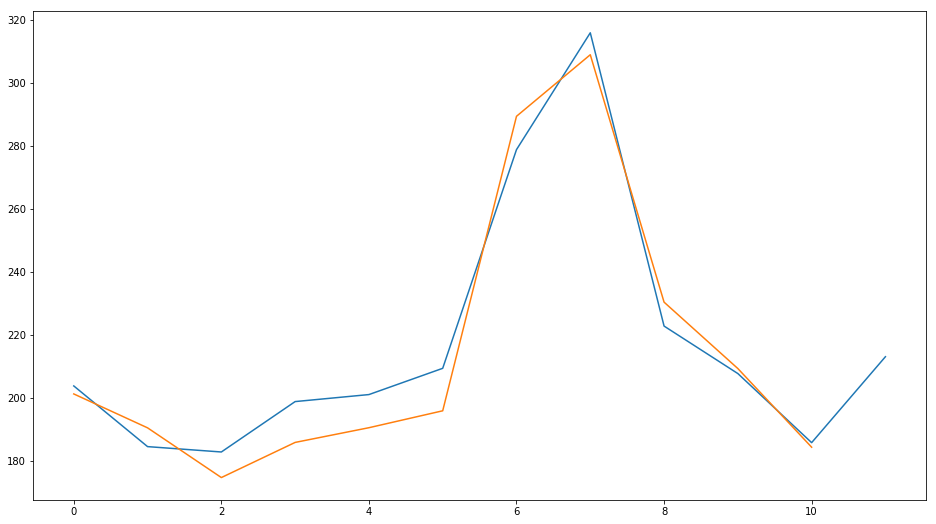

In [10]:
plt.plot(meses['2017'].values)
plt.plot(meses['2018'].values)

* Se puede observar que la tencia de ambos periodos en estudio se aproxima bastante a nivel de promedios y que los peak de ventas se encuentran en los meses de Junio y Julio. Miremos con mayor detalles que ocurre en este intervalo de tiempo.

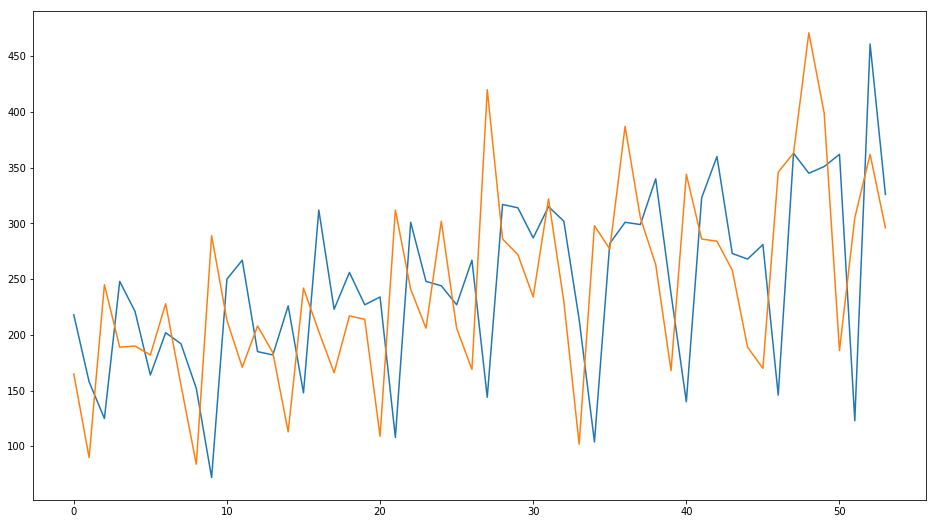

In [11]:
verano2017 = df['2017-06-01':'2017-08-01']
plt.plot(verano2017.values)

verano2018 = df['2018-06-01':'2018-08-01']
plt.plot(verano2018.values)

* Perfecto! Ya entendemos el macro comportamiento de nuestra serie de tiempo, pasemos ahora al proceso de ferecasting, la prediccion en base a los datos temporales

* Una etapa relevante para que nuestro modelo pueda predecir correctamente, es re estructurando el dataset para poder utilizar tecnicas de entrenamiento supervisado X -> Y. Para ello crearemos un nuevo dataset a partir de nuestro dataset original, primero estandandarizando los datos para que los pueda utilizar una red neuronal [-1, 1] y luego creando nuevas columnas para entrenamiento.

In [12]:
# Function to convert series to supervised learning
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
        else:
            names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

* Estandarizamos el dataset

In [13]:
# Load dataset
values = df.values.astype('float32')

# Normalize features
scaler = MinMaxScaler(feature_range=(-1, 1))
values = values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
scaled = scaler.fit_transform(values)
scaled[1:10]

array([[-0.31111115],
       [-0.11481488],
       [-0.3703704 ],
       [-0.71481484],
       [-0.10370374],
       [-0.22592598],
       [-0.43333334],
       [-0.60740745],
       [-0.5222223 ]], dtype=float32)

* Creamos el nuevo dataset utilizando los datos normalizados, se creará un dataset con 8 columnas

In [14]:
reframed = series_to_supervised(scaled, 7, 1)
reframed.head()

,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1),var1(t)
7,-0.314815,-0.311111,-0.114815,-0.370370,-0.714815,-0.103704,-0.225926,-0.433333
8,-0.311111,-0.114815,-0.370370,-0.714815,-0.103704,-0.225926,-0.433333,-0.607407
9,-0.114815,-0.370370,-0.714815,-0.103704,-0.225926,-0.433333,-0.607407,-0.522222
10,-0.370370,-0.714815,-0.103704,-0.225926,-0.433333,-0.607407,-0.522222,-0.644444
11,-0.714815,-0.103704,-0.225926,-0.433333,-0.607407,-0.522222,-0.644444,-0.344444


* En este caso, X es igual a las columasn var1(t-7), a la columa var1(t-1), y el valor Y es igual a la columan var1(t).

* Bien! Ya tenemos el dataset, ahora procederemos a dividir los datos en data de entrenamiento y de testing.

In [15]:
# split into train and test sets
values = reframed.values
n_train_days = 315+289 - (30+7)

train = values[:n_train_days, :]
test = values[n_train_days:, :]

In [16]:
# split into input and outputs
x_train, y_train = train[:, :-1], train[:, -1]
x_val, y_val = test[:, :-1], test[:, -1]

In [17]:
# reshape input to be 3D [samples, timesteps, features]
x_train = x_train.reshape((x_train.shape[0], 1, x_train.shape[1]))
x_val = x_val.reshape((x_val.shape[0], 1, x_val.shape[1]))

print(x_train.shape, y_train.shape, x_val.shape, y_val.shape)

((567, 1, 7), (567,), (30, 1, 7), (30,))


* Se observan 567 vectores de entrada con dimension 1 X 7

### Red  Neuronal:
Utilizaremos una arquitectura MLP con las siguientes caracteristicas

* Entrada 7 inputs (1 X 7)
* 1 capa oculta con 7 neuronas
* La salida será 1 sola neurona
* Como función de activación utilizamos tangente hiperbólica puesto que utilizaremos valores entre -1 y 1.
* Utilizaremos como optimizador Adam y métrica de pérdida (loss) Mean Absolute Error
* Como la predicción será un valor continuo y no discreto, para calcular el Acuracy utilizaremos Mean Squared Error y para saber si mejora con el entrenamiento se debería ir reduciendo con las EPOCHS.

In [18]:
def crear_modeloFF():
    model = Sequential() 
    model.add(Dense(7, input_shape=(1,7),activation='tanh'))
    model.add(Flatten())
    model.add(Dense(1, activation='tanh'))
    model.compile(loss='mean_absolute_error',optimizer='Adam',metrics=["mse"])
    model.summary()
    return model

In [23]:
EPOCHS=100
 
model = crear_modeloFF()
 
history = model.fit(x_train, y_train, epochs=EPOCHS, validation_data = (x_val, y_val), batch_size=7)

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_3 (Dense)              (None, 1, 7)              56        
_________________________________________________________________
flatten_2 (Flatten)          (None, 7)                 0         
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 8         
Total params: 64
Trainable params: 64
Non-trainable params: 0
_________________________________________________________________
Train on 567 samples, validate on 30 samples
Epoch 1/100
567/567 [==============================] - 0s 615us/step - loss: 0.2160 - mean_squared_error: 0.0805 - val_loss: 0.1814 - val_mean_squared_error: 0.0496
Epoch 2/100
567/567 [==============================] - 0s 304us/step - loss: 0.1961 - mean_squared_error: 0.0695 - val_loss: 0.1673 - val_mean_squared_error: 0.0436
Epoch 3/100
567/567 [==============

Epoch 46/100
567/567 [==============================] - 0s 322us/step - loss: 0.1677 - mean_squared_error: 0.0546 - val_loss: 0.1388 - val_mean_squared_error: 0.0354
Epoch 47/100
567/567 [==============================] - 0s 306us/step - loss: 0.1676 - mean_squared_error: 0.0546 - val_loss: 0.1388 - val_mean_squared_error: 0.0348
Epoch 48/100
567/567 [==============================] - 0s 307us/step - loss: 0.1681 - mean_squared_error: 0.0543 - val_loss: 0.1387 - val_mean_squared_error: 0.0349
Epoch 49/100
567/567 [==============================] - 0s 422us/step - loss: 0.1674 - mean_squared_error: 0.0544 - val_loss: 0.1383 - val_mean_squared_error: 0.0346
Epoch 50/100
567/567 [==============================] - 0s 354us/step - loss: 0.1677 - mean_squared_error: 0.0549 - val_loss: 0.1380 - val_mean_squared_error: 0.0348
Epoch 51/100
567/567 [==============================] - 0s 365us/step - loss: 0.1675 - mean_squared_error: 0.0548 - val_loss: 0.1388 - val_mean_squared_error: 0.0345
Epoc

567/567 [==============================] - 0s 685us/step - loss: 0.1632 - mean_squared_error: 0.0512 - val_loss: 0.1393 - val_mean_squared_error: 0.0346
Epoch 96/100
567/567 [==============================] - 0s 542us/step - loss: 0.1629 - mean_squared_error: 0.0511 - val_loss: 0.1382 - val_mean_squared_error: 0.0349
Epoch 97/100
567/567 [==============================] - 0s 682us/step - loss: 0.1628 - mean_squared_error: 0.0513 - val_loss: 0.1387 - val_mean_squared_error: 0.0345
Epoch 98/100
567/567 [==============================] - 0s 494us/step - loss: 0.1617 - mean_squared_error: 0.0509 - val_loss: 0.1399 - val_mean_squared_error: 0.0346
Epoch 99/100
567/567 [==============================] - 0s 339us/step - loss: 0.1623 - mean_squared_error: 0.0511 - val_loss: 0.1399 - val_mean_squared_error: 0.0346
Epoch 100/100
567/567 [==============================] - 0s 354us/step - loss: 0.1623 - mean_squared_error: 0.0507 - val_loss: 0.1384 - val_mean_squared_error: 0.0344


* El valor de mean_squared_error es igual a 0.0374 y el loss=0.14

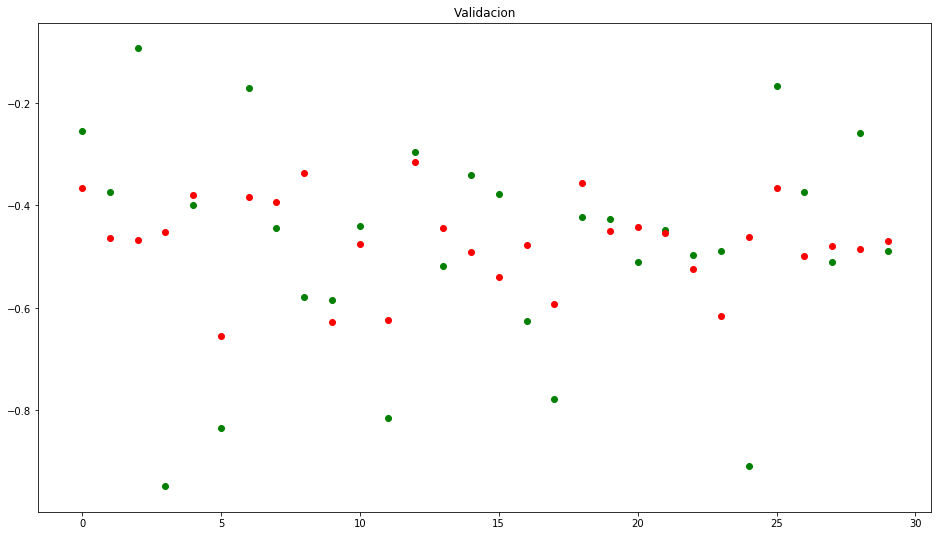

In [24]:
results = model.predict(x_val)
plt.scatter(range(len(y_val)),y_val,c='g')
plt.scatter(range(len(results)),results,c='r')
plt.title('Validacion')
plt.show()

* Se observa una tendencia clara para en igualar los valores de los puntos verdes respecto de los puntos rojos. Aumentando los EPOCH mejora la aproximación

* A continuación se puede observar la curvas de entrenamiento y validacion son distintas.

In [29]:
# list all data in history
print(history.history.keys())

['mean_squared_error', 'loss', 'val_mean_squared_error', 'val_loss']


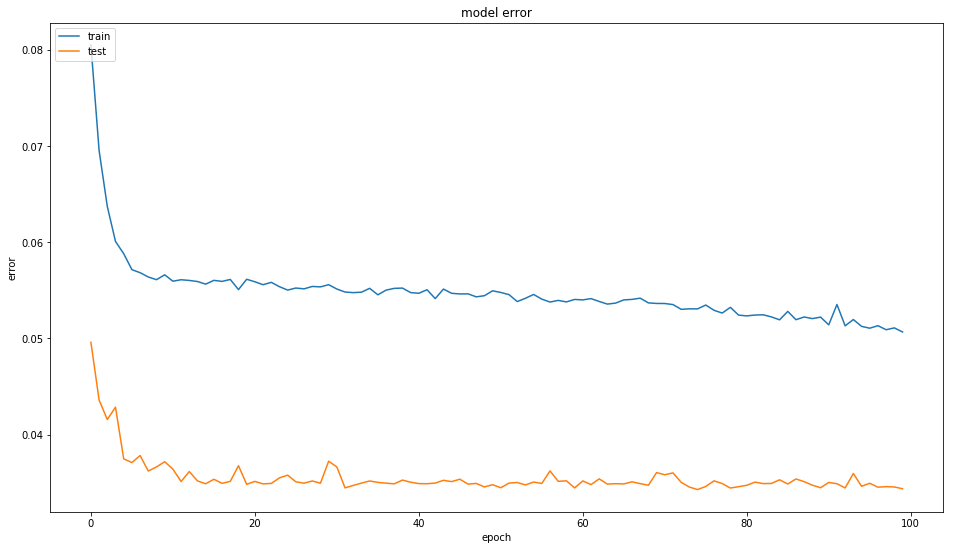

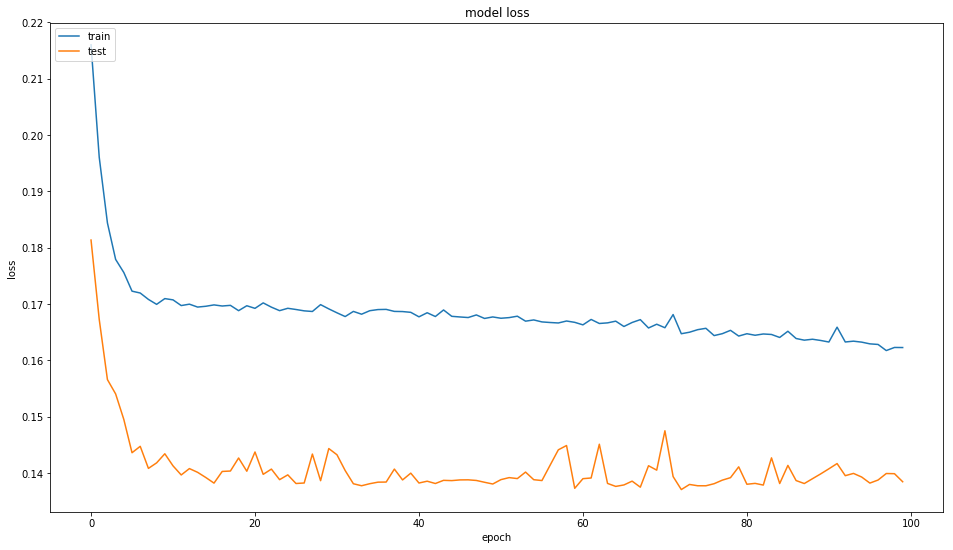

In [31]:
# summarize history for error
plt.plot(history.history['mean_squared_error'])
plt.plot(history.history['val_mean_squared_error'])
plt.title('model error')
plt.ylabel('error')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

* Ahora realizaremos la tarea de predecir las ventas futuras con el modelo que hemos construido

In [32]:
ultimosDias = df['2018-11-16':'2018-11-30']
ultimosDias

fecha
2018-11-16    152
2018-11-17    111
2018-11-19    207
2018-11-20    206
2018-11-21    183
2018-11-22    200
2018-11-23    187
2018-11-24    189
2018-11-25     76
2018-11-26    276
2018-11-27    220
2018-11-28    183
2018-11-29    251
2018-11-30    189
Name: unidades, dtype: int64

* Replicaremos la metodologia utilizada en el entrenamiento para estandarizar las entreda

In [34]:
values = ultimosDias.values.astype('float32')

# Normalize features
values=values.reshape(-1, 1) # esto lo hacemos porque tenemos 1 sola dimension
scaled = scaler.fit_transform(values)

reframed = series_to_supervised(scaled, 7, 1)
reframed.drop(reframed.columns[[7]], axis=1, inplace=True)
reframed.head(7)

,var1(t-7),var1(t-6),var1(t-5),var1(t-4),var1(t-3),var1(t-2),var1(t-1)
7,-0.24,-0.65,0.31,0.30,0.07,0.24,0.11
8,-0.65,0.31,0.30,0.07,0.24,0.11,0.13
9,0.31,0.30,0.07,0.24,0.11,0.13,-1.00
10,0.30,0.07,0.24,0.11,0.13,-1.00,1.00
11,0.07,0.24,0.11,0.13,-1.00,1.00,0.44
12,0.24,0.11,0.13,-1.00,1.00,0.44,0.07
13,0.11,0.13,-1.00,1.00,0.44,0.07,0.75


* De este conjunto, tomamos la ultim fila que corresponde a la ultima semana.

In [41]:
values = reframed.values
x_test = values[6:, :]
x_test = x_test.reshape((x_test.shape[0], 1, x_test.shape[1]))
x_test

array([[[ 0.11000001,  0.13      , -1.        ,  1.        ,
          0.44000006,  0.06999993,  0.75      ]]], dtype=float32)

* Creamos la funcion que rellenando los desplazamientos

In [45]:
def agregarNuevoValor(x_test,nuevoValor):
    for i in range(x_test.shape[2]-1):
        x_test[0][0][i] = x_test[0][0][i+1]
    x_test[0][0][x_test.shape[2]-1]=nuevoValor
    return x_test

In [46]:
results=[]
for i in range(7):
    parcial=model.predict(x_test)
    results.append(parcial[0])
    print(x_test)
    x_test=agregarNuevoValor(x_test,parcial[0])

[[[-0.04606373 -0.2445725  -0.00251446  0.33658338  0.05690176
    0.28905064 -0.03941593]]]
[[[-0.2445725  -0.00251446  0.33658338  0.05690176  0.28905064
   -0.03941593 -0.10869711]]]
[[[-0.00251446  0.33658338  0.05690176  0.28905064 -0.03941593
   -0.10869711 -0.08013865]]]
[[[ 0.33658338  0.05690176  0.28905064 -0.03941593 -0.10869711
   -0.08013865  0.11738003]]]
[[[ 0.05690176  0.28905064 -0.03941593 -0.10869711 -0.08013865
    0.11738003 -0.00349817]]]
[[[ 0.28905064 -0.03941593 -0.10869711 -0.08013865  0.11738003
   -0.00349817  0.04791868]]]
[[[-0.03941593 -0.10869711 -0.08013865  0.11738003 -0.00349817
    0.04791868 -0.07575817]]]


* Las predicciones estan en el entre el -1, y el 1, por lo que tenemos que aplicar una funciona para desnormaliar para obtener la escala real

In [47]:
adimen = [x for x in results]    
inverted = scaler.inverse_transform(adimen)
inverted

array([[165.13029184],
       [167.98613745],
       [187.73800629],
       [175.65018627],
       [180.79187082],
       [168.4241854 ],
       [164.47754646]])

In [51]:
prediccion1SemanaDiciembre = pd.DataFrame(inverted)
prediccion1SemanaDiciembre.columns = ['forecasting']
prediccion1SemanaDiciembre.to_csv('./data/pronostico.csv')

In [52]:
prediccion1SemanaDiciembre

,forecasting
0,165.130292
1,167.986137
2,187.738006
3,175.650186
4,180.791871
5,168.424185
6,164.477546


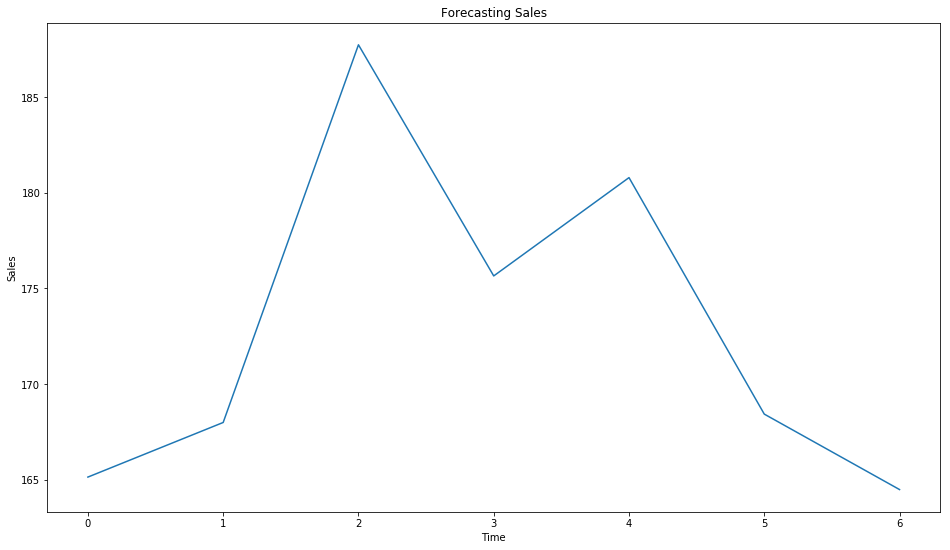

In [54]:
plt.plot(prediccion1SemanaDiciembre.forecasting)
plt.title('Forecasting Sales')
plt.ylabel('Sales')
plt.xlabel('Time')
plt.show()